# Análisis de una serie de tiempos - la referencia n.º 1004767

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
import gc

In [3]:
# Configuraciones
# pyplot
plt.style.use('Solarize_Light2')
plt.rcParams["figure.figsize"] = (10,3)
# Matplotlib
register_matplotlib_converters()

In [4]:
# Carga del dataset original para extraer un subset con las referencias más vendidas
pd_sales_multistore = pd.read_csv('sales_multistore_10_2019_04_2020.csv',
                    header=0,
                    index_col=0,
                    parse_dates=['event_time'],
                    infer_datetime_format=True
                    )

In [4]:
pd_sales_multistore_1004767 = pd_sales_multistore[pd_sales_multistore['product_id'] == 1004767]

In [5]:
pd_sales_multistore_1004767.head(5)

,product_id,category_id,category_code,brand,price,user_id,user_session
event_time,,,,,,,
2019-10-01 02:23:39+00:00,1004767,2053013555631882655,electronics.smartphone,samsung,254.82,512730342,4a34d086-4940-45e1-b70b-b04b1b8e96aa
2019-10-01 02:33:21+00:00,1004767,2053013555631882655,electronics.smartphone,samsung,254.82,523751849,6d302422-8cbc-45c1-9bf6-729b63c93393
2019-10-01 02:38:49+00:00,1004767,2053013555631882655,electronics.smartphone,samsung,254.82,543624132,e5d9229b-09a3-4bcd-8410-4af1b9cba01a
2019-10-01 02:40:17+00:00,1004767,2053013555631882655,electronics.smartphone,samsung,254.82,534178501,5499a976-a71c-4882-8497-20397255f7d1
2019-10-01 02:43:22+00:00,1004767,2053013555631882655,electronics.smartphone,samsung,254.82,512730342,403d3545-0e32-4d7d-a6ef-eb75efc7be38


In [6]:
# Le aplicamos las transformaciones de dtype que aplicamos al dataset completo en la EDA
pd_sales_multistore_1004767 = pd_sales_multistore_1004767.astype({"product_id":'int32', "category_id":'int64', \
                                                   "category_code":'category', "brand":'category', \
                                                   "price":'string[pyarrow]', "user_session":'string[pyarrow]'})

In [7]:
# Eliminamos el dataset original completo de la memoria
del pd_sales_multistore
gc.collect()
pd_sales_multistore=pd.DataFrame()

La agregación que aplicamos a los datos es **diaria**, porque nuestro cliente realiza el balance de ventas, el cálculo de stocks y la previsión de pedidos de compra con una periodicidad diaria.

In [8]:
pd_sales_multistore_1004767_daily = pd_sales_multistore_1004767.resample('D').count()['user_session']. \
to_frame().rename(columns={'user_session' : 'units_sold'})

## 1. Exploración inicial

### 1.1 Evolución de las ventas (diarias, semanales, mensuales)

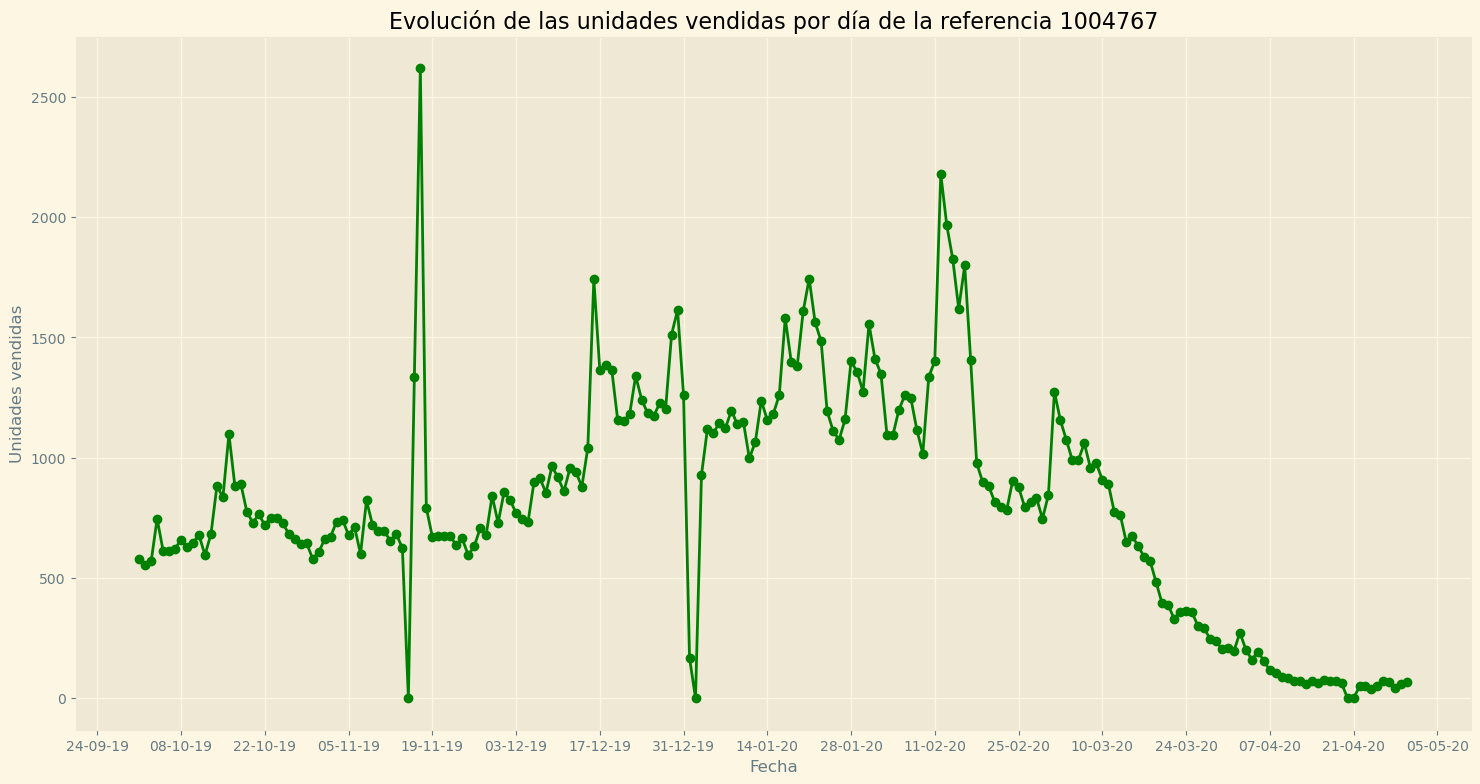

In [9]:
# sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(pd_sales_multistore_1004767_daily.index,
        pd_sales_multistore_1004767_daily['units_sold'],
        '-o',
        color='green')
ax.set(xlabel="Fecha", ylabel="Unidades vendidas",
       title="Evolución de las unidades vendidas por día de la referencia 1004767")

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

plt.show()

A modo comparativo vamos a plotear el número de unidades vendidas por semana y por mes, para intentar apreciar estacionalidades y ciclos.

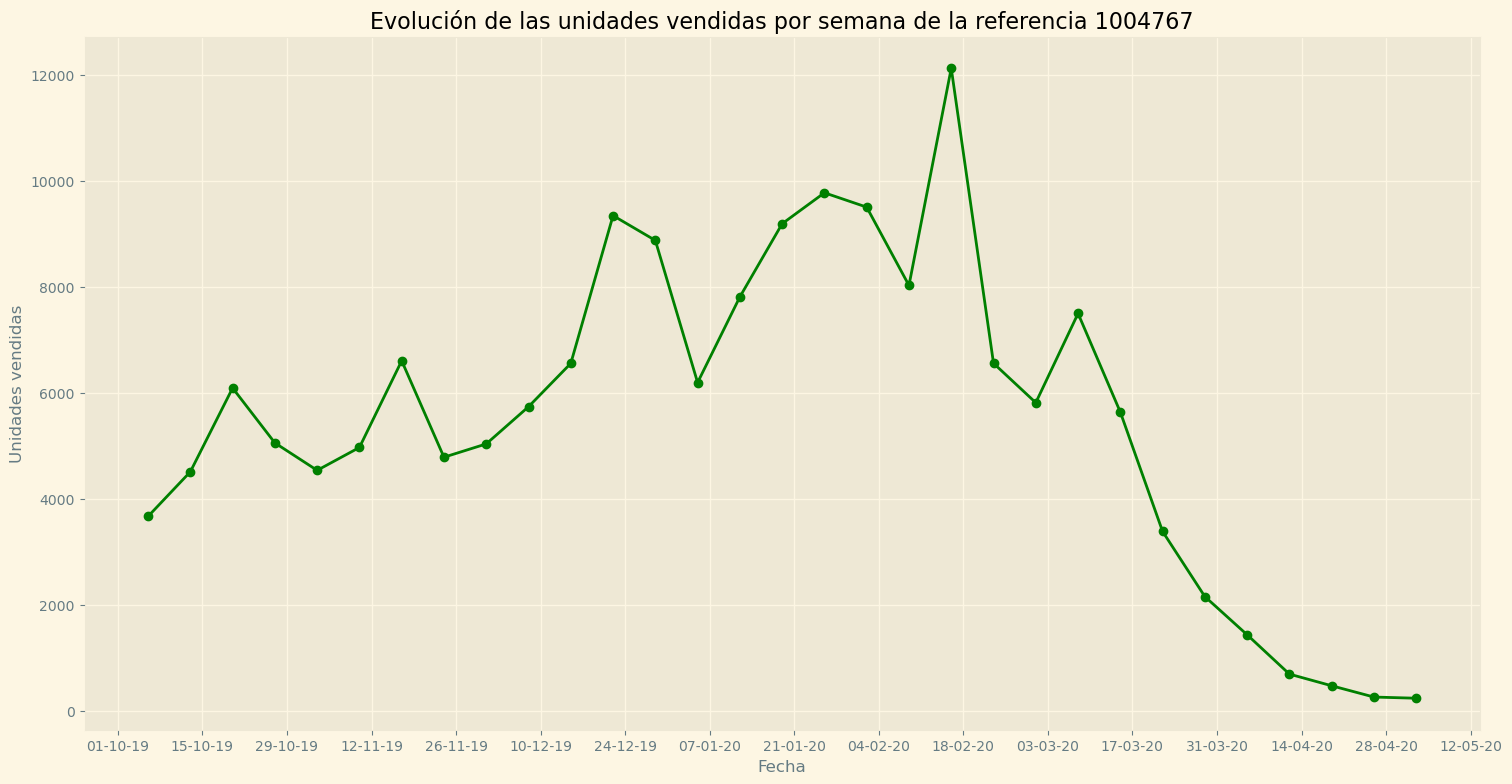

In [10]:
pd_sales_multistore_1004767_weekly = pd_sales_multistore_1004767['user_session'] \
.resample('W').count().to_frame().rename(columns={'user_session' : 'units_sold'})

# sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(pd_sales_multistore_1004767_weekly.index,
        pd_sales_multistore_1004767_weekly['units_sold'],
        '-o',
        color='green')
ax.set(xlabel="Fecha", ylabel="Unidades vendidas",
       title="Evolución de las unidades vendidas por semana de la referencia 1004767")

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

plt.show()

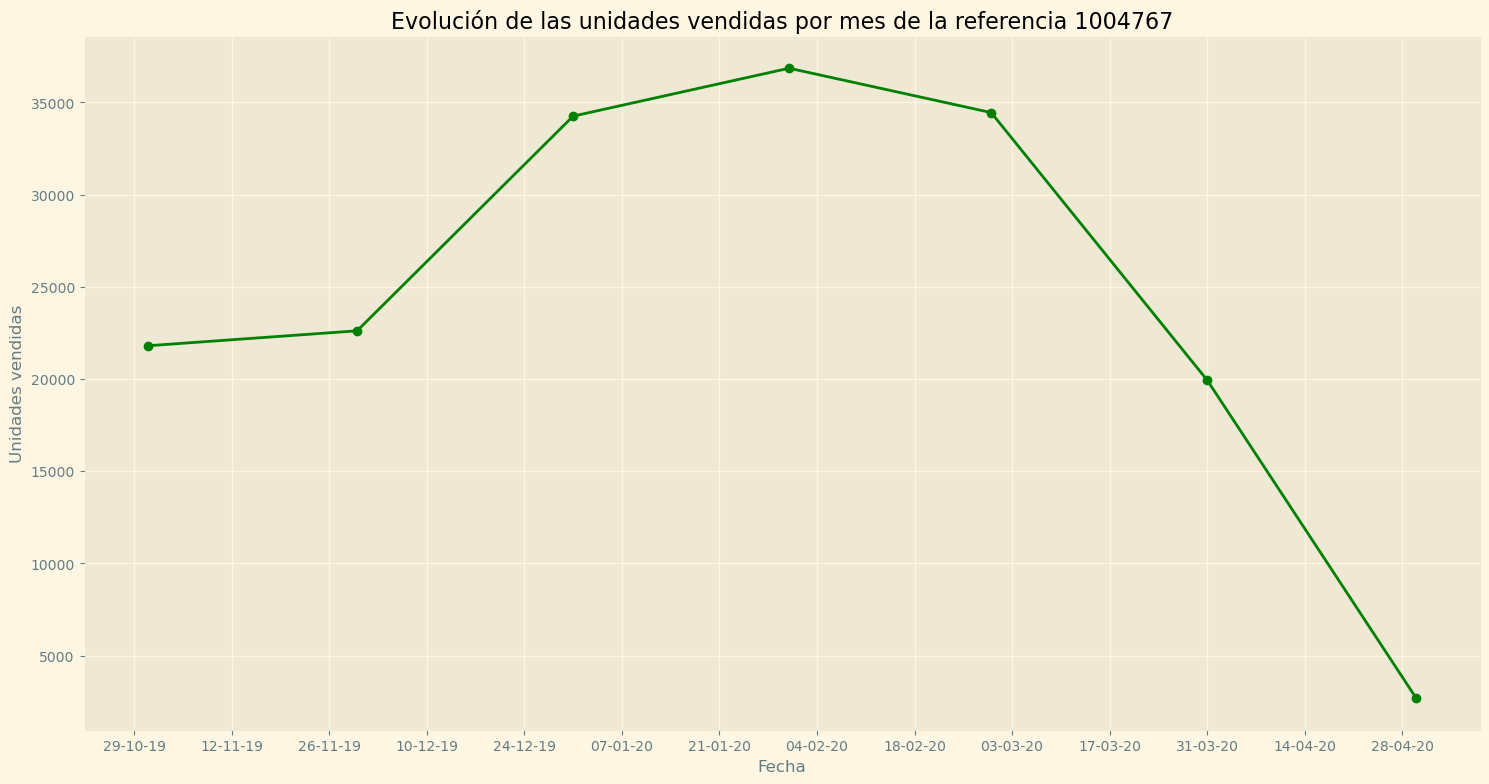

In [11]:
pd_sales_multistore_1004767_monthly = pd_sales_multistore_1004767['user_session'] \
.resample('M').count().to_frame().rename(columns={'user_session' : 'units_sold'})

# sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(pd_sales_multistore_1004767_monthly.index,
        pd_sales_multistore_1004767_monthly['units_sold'],
        '-o',
        color='green')
ax.set(xlabel="Fecha", ylabel="Unidades vendidas",
       title="Evolución de las unidades vendidas por mes de la referencia 1004767")

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

plt.show()

Evidentemente estamos hablando de una serie de tiempos no estacionaria, es decir, que no tiene una media y una varianza constante. Se aprecian efectos de tendencia considerables y una estacionalidad semanal.

En el apartado siguiente analizaremos la estacionaridad de la serie por medio de un plot de autocorrelación.

### 1.2 Plots de *Lag Scatter* y de autocorrelación

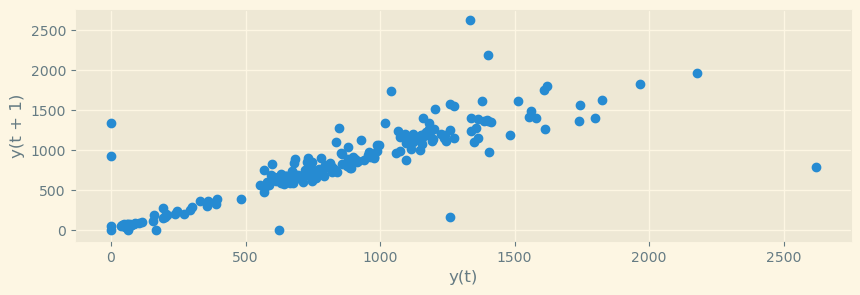

In [12]:
from pandas.plotting import lag_plot

lag_plot(pd_sales_multistore_1004767_daily)
plt.show()

Se da una correlación positiva bastante ajustada entre cada día y el día siguiente en la línea de tiempos.

Vamos a representar plots de puntos para diferentes decalajes (*lags*), para detectar otros tipos de relaciones.

In [13]:
values = pd.DataFrame(pd_sales_multistore_1004767_daily.values.flatten())
lags = 7
columns = [values]

for i in range(1,(lags + 1)):
     columns.append(values.shift(i))

In [14]:
lags_dataframe = pd.concat(columns, axis=1)

In [15]:
headers = ['t']
for i in range(1,(lags + 1)):
    headers.append('t-' + str(i))

lags_dataframe.columns = headers

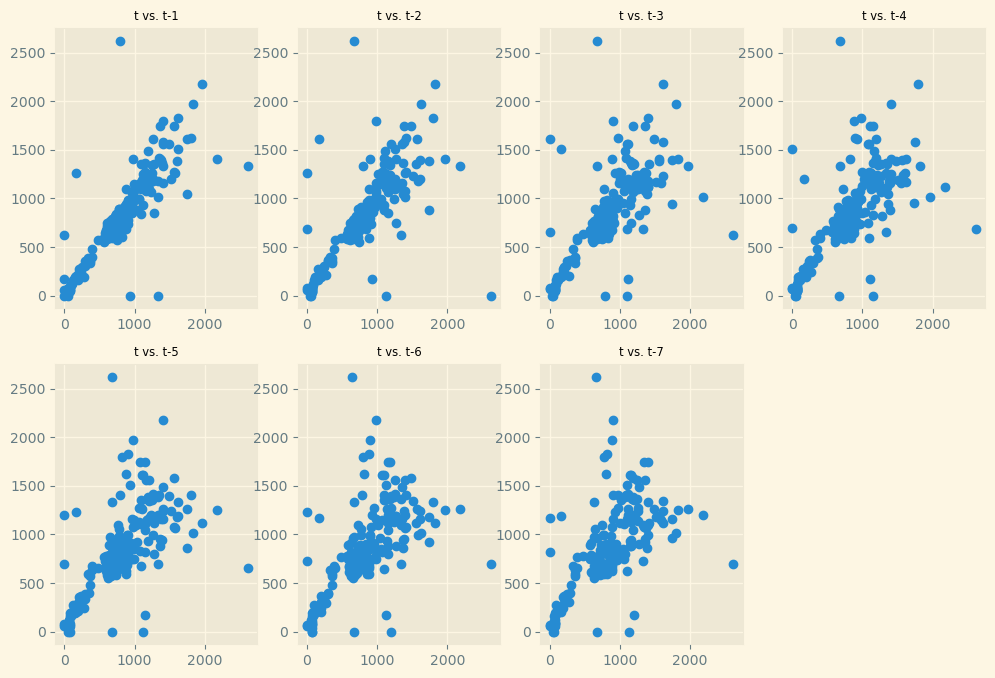

In [22]:
plt.figure(1)
plt.rcParams.update({'axes.titlesize': 'small', 'figure.figsize': (12,6)})

for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t vs. t-' + str(i))
    plt.scatter(x=lags_dataframe['t'].values, y=lags_dataframe['t-'+str(i)].values)

plt.show()

La mejor correlación se da con el *lag* de 1 día y empeora algo a medida que aumentamos el número de días para este parámetro.

Vamos a representar ahora el plot de autocorrelación:

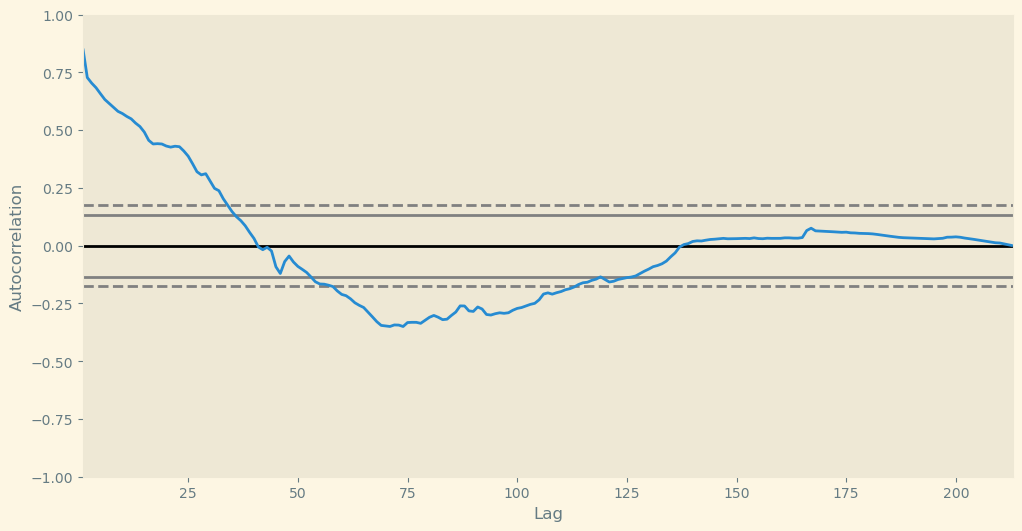

In [36]:
autocorrelation_plot(pd_sales_multistore_1004767_daily["units_sold"])
plt.show()

Se aprecia una correlación positiva no muy alta, que desciende rápidamente hasta valores no significativos para un *lag* de unos 32-35 días. La correlación vuelve a valores significativos, pero esta vez negativos a partir de los 55-60 días de *lag* y retorna a la zona estadísticamente no significativa a los aprox. 120 días, para ya no recuperar la zona de significancia.

La curva apunta a una fuerte componente de tendencia, sin estacionalidad evidente, porque no se aprencian "periodos" en la curva.

Veamos otro plot de autocorrelación, esta vez de coeficientes de Pearson.

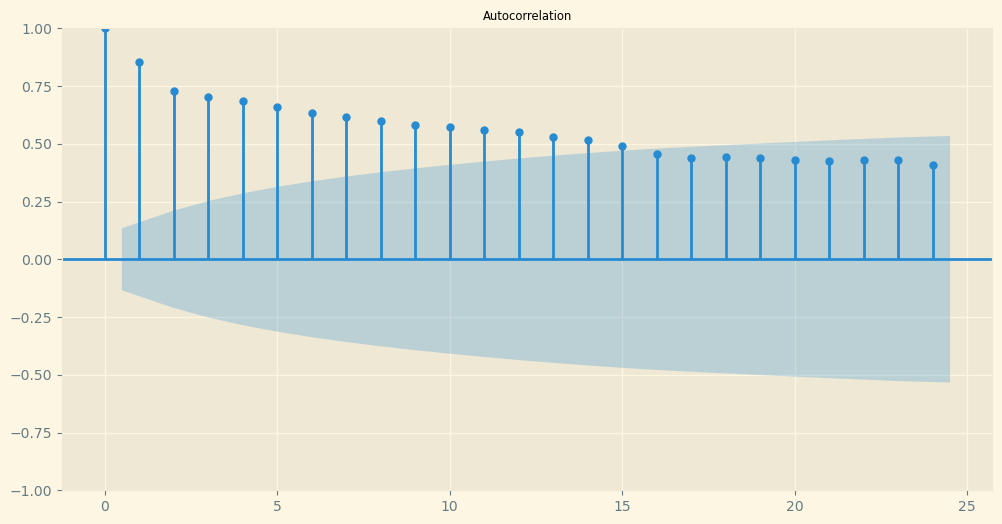

In [71]:
fig = plot_acf(pd_sales_multistore_1004767_daily["units_sold"])
plt.show()

## 2. Descomposición de la serie de tiempos: tendencia, estacionalidad y residuales

Vamos a descomponer la serie de tiempos del producto más vendido en la web, que es la referencia n.º 1004767.

Se trata de averiguar la tendencia, la estacionalidad y los residuales.
Para ello vamos a utilizar el método **STL** (Seasonal and Trend decomposition using Loess), dada su versatilidad para manejar estacionalidades con diferentes periodos (no solo mensuales o trimestrales). Además, la estacionalidad puede variar a lo largo del tiempo. Las observaciones que se salen de la normalidad (*outliers*) no afectan a la estimación de la tendencia y de la estacionalidad, aunque sí se reflejan en los residuales.
STL tiene la desventaja de que solo permite descomposiciones aditivas, aunque se puede obtener una descomposición multiplicativa haciendo primero un log de los valores, para luego volver a exponenciarlos.

Vamos a estimar en primer lugar mediante un plot si se trata de un modelo de serie de tiempos **aditivo** (la estacionalidad no cambia a lo largo del tiempo) o de un modelo **multiplicativo** (la estacionalidad fluctúa).

Dado lo corto del periodo cubierto por el dataset, resulta difícil observar una tendencia y una estacionalidad y casi imposible apreciar un comportamiento cícilico. Podemos hablar de una tendencia descendente, con picos máximos a mediados de noviembre de 2019 y mediados de febrero de 2020 y picos mínimos justo antes del pico de noviembre de 2019 y durante los primeros días de 2020.
Deducimos que el pico alto de febrero de 2020 puede coincidir con la campaña comercial del Año Nuevo chino, cuyas fechas van desde mediados de enero hasta finales de febrero (dependiendo del año, puesto que el calendario chino es lunar).

Vamos a aplicar el método STL aditivo, porque entendemos que este pico y, quizá el de noviembre de 2019, son periódicos.

In [41]:
plt.rcParams["figure.figsize"] = (12,16)
pd_sales_multistore_1004767_stl = STL(pd_sales_multistore_1004767_daily,
                                  seasonal=13,
                                  robust=True).fit()

### 2.1 Tendencia

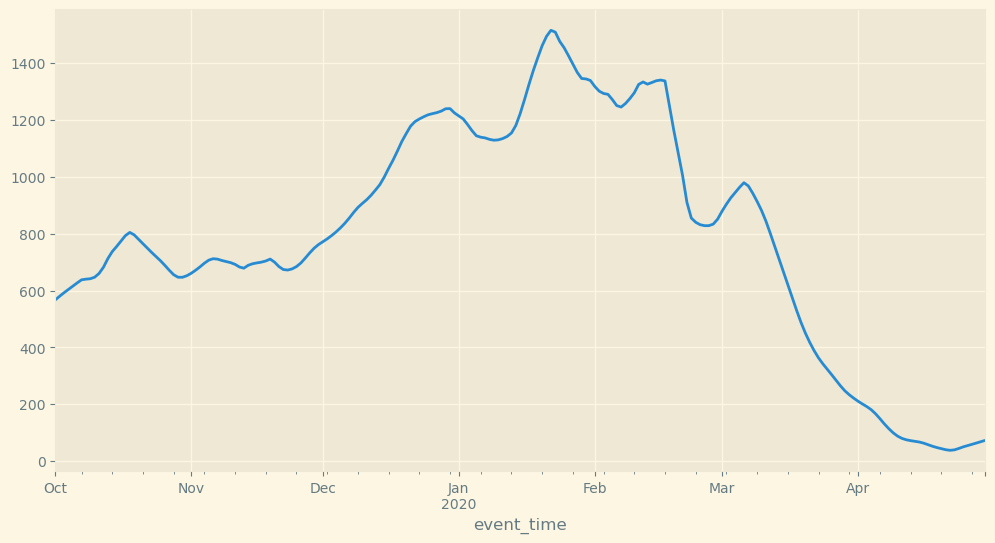

In [42]:
plt.rcParams["figure.figsize"] = (12,6)
pd_sales_multistore_1004767_stl.trend.plot()
plt.show()

Se aprecia la tendencia sostenida a la baja a partir del 7 de marzo de 2020. Nos faltan datos para ver cuándose se produce un punto de inflexión a la tendencia ascendente que se observa también en los meses finales del año anterior.

### 2.2 Estacionalidad

Ploteamos la serie de tiempos para analizar la estacionalidad.

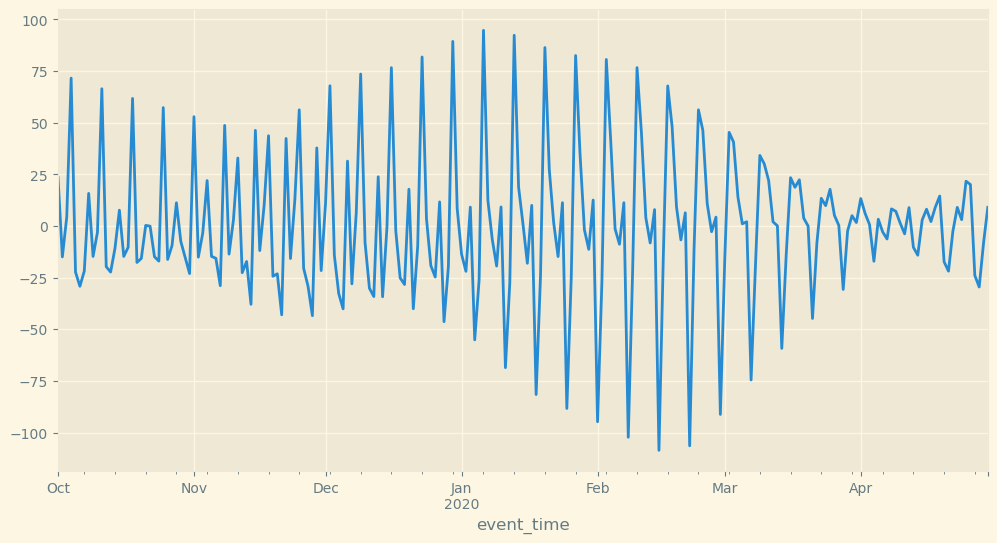

In [43]:
pd_sales_multistore_1004767_stl.seasonal.plot()
plt.show()

Se observa claramente una estacionalidad "semanal", donde los picos coinciden con los fines de semana y las "simas" con el principio de la semana.

Vamos a poner la lupa sobre uno de los meses sin *outliers*, octubre:

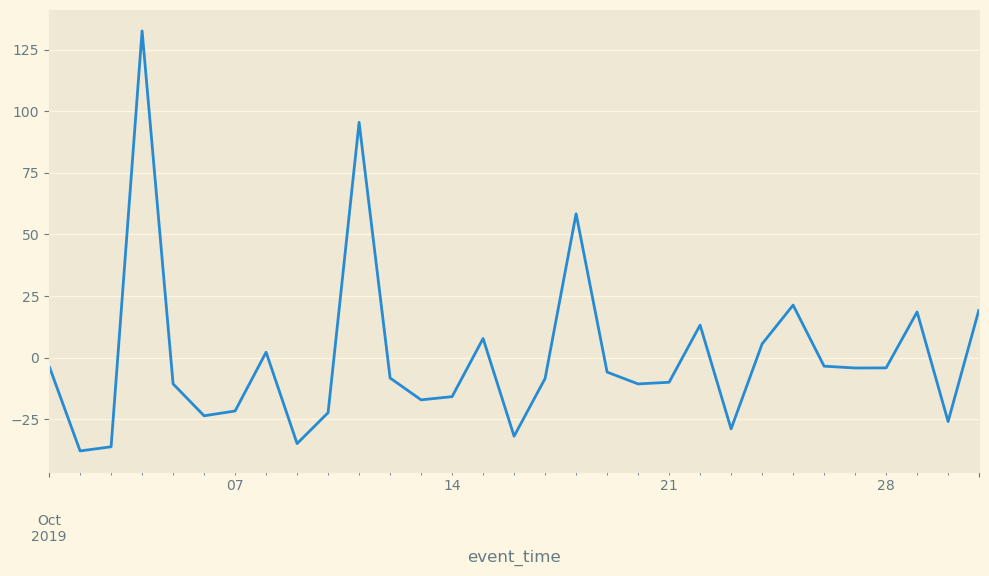

In [44]:
pd_sales_multistore_1004767_stl_october = STL(pd_sales_multistore_1004767_daily[pd_sales_multistore_1004767_daily.index.month == 10],
                                  seasonal=13,
                                  robust=True).fit()
pd_sales_multistore_1004767_stl_october.seasonal.plot()
plt.show()

### 2.3 Residuales

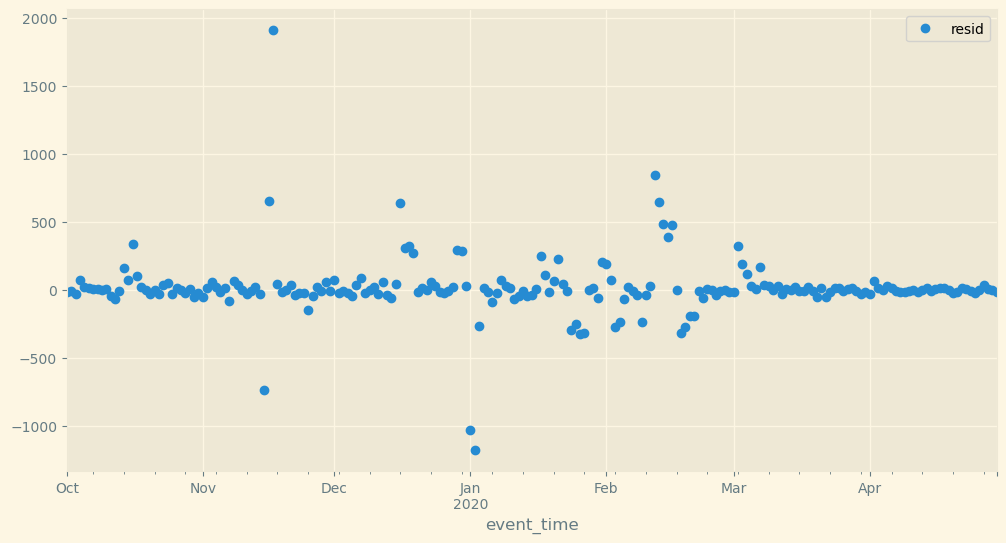

In [45]:
pd_sales_multistore_1004767_stl.residuals = pd_sales_multistore_1004767_stl.resid.to_frame()
pd_sales_multistore_1004767_stl.residuals.plot(style='o')
plt.show()
# El uso de plot.scatter da error cuando se definen los ejes x e y (ver:
# https://stackoverflow.com/questions/54755978/scatter-plots-matplotlib-dealing-with-pandas-datetime-as-index)

Los residuales más significativos coinciden con los picos "alto" y "bajo" de noviembre de 2019, con el pico "bajo" de principios de 2020 y con el pico "alto" de mitad de febrero de 2020.

### 2.4 Segregación de las variaciones cíclicas de las tendencias a largo plazo

El filtro de *Hodrick-Prescott* se puede utilizar para separar las fluctuaciones de corta duración (variaciones cíclicas) de las tendencias a largo plazo.

In [46]:
from statsmodels.tsa.filters.hp_filter import hpfilter

plt.rcParams["figure.figsize"] = (12,6)

pd_sales_multistore_1004767_cyclic, pd_sales_multistore_1004767_trend = hpfilter(pd_sales_multistore_1004767_daily)

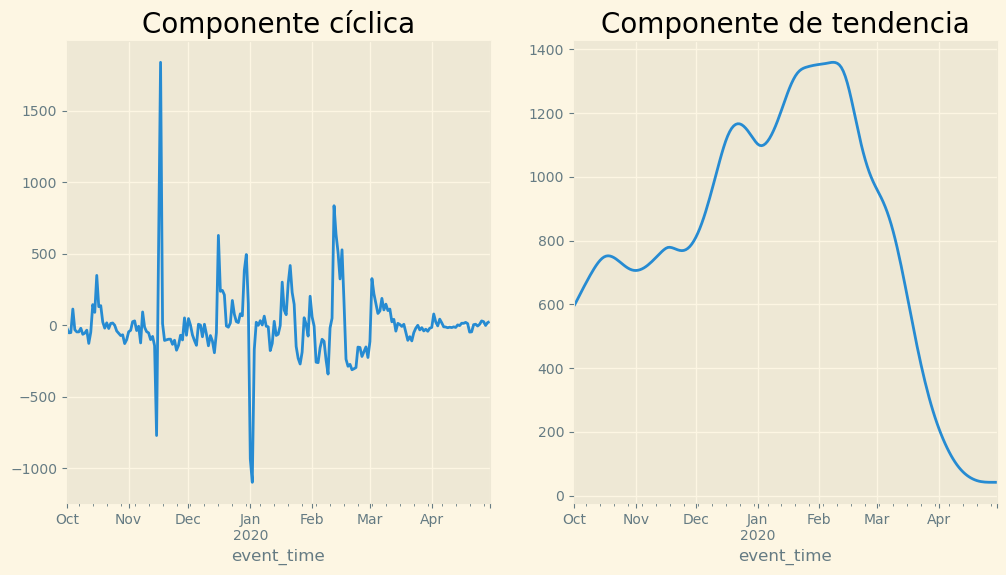

In [47]:
fig, ax = plt.subplots(1,2)
pd_sales_multistore_1004767_cyclic.plot(ax=ax[0], title='Componente cíclica')
pd_sales_multistore_1004767_trend.plot(ax=ax[1], title='Componente de tendencia')
ax[0].title.set_size(20); ax[1].title.set_size(20)

## 3. ¿Es estacionaria la serie de tiempos analizada?

*Estacionariedad* significa que la *media*, la *varianza* y la *autocorrelación* no cambian con el tiempo, facilitando la labor de predicción a partir de la serie de tiempos dada.

Comenzaremos realizando un test *ADF* (Augmented Dickey-Fuller), que es un test estadístico para determinar si existe una raíz unitaria.

### 3.1 Test ADF

In [53]:
from statsmodels.tsa.stattools import adfuller

In [54]:
resultado_adf = adfuller(pd_sales_multistore_1004767_daily)

In [55]:
pval = resultado_adf[1]

print("El valor 'p' en el test ADF es {}".format(pval))

El valor 'p' en el test ADF es 0.3977521928680812


'pval' es mayor o igual que 0.05, con lo cual la serie de tiempos **NO** es estacionaria según el test *ADF*, algo que ya era de prever vistos los plots anteriores.

### 3.2 Transformación en una serie estacionaria

Ahora se trata de transformar la serie de tiempos para que sea estacionaria. La forma de hacerlo es eliminando los efectos de tendencia y de estacionalidad. Vamos a probar diferentes estrategias para conseguirlo.



#### 3.2.1 Resta de la media semanal

Agregamos por semanas y sacamos la media, para luego aplicar la diferencia.

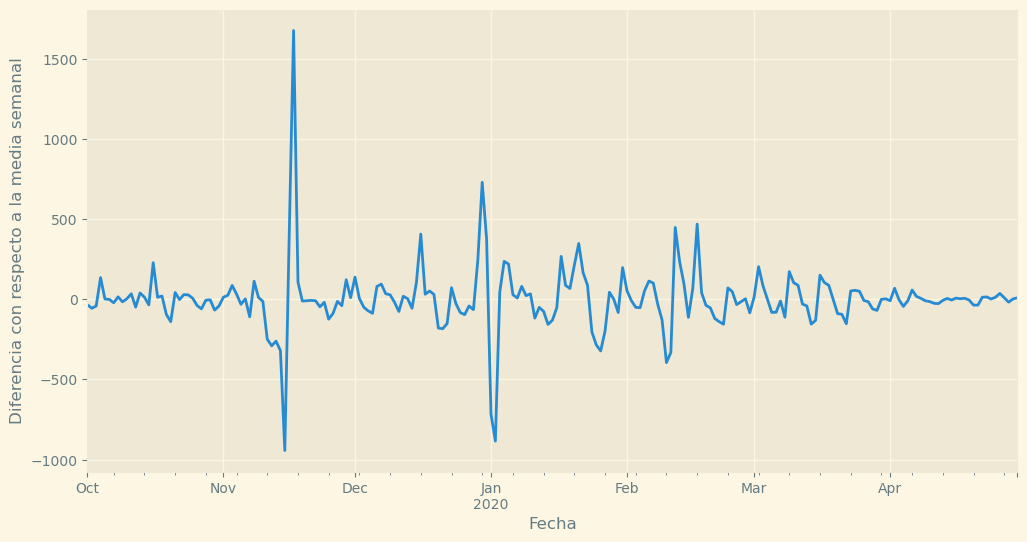

In [59]:
pd_sales_multistore_1004767_daily_wm = pd_sales_multistore_1004767_daily.resample("W").transform(lambda x: x-x.mean())
pd_sales_multistore_1004767_daily_wm.plot(legend=False, xlabel="Fecha", ylabel="Diferencia con respecto a la media semanal")
plt.show()

Realizamos el test ADF de la serie transformada:

In [60]:
resultado_adf = adfuller(pd_sales_multistore_1004767_daily_wm)
pval = resultado_adf[1]

print("El valor 'p' en el test ADF es {}".format(pval))

El valor 'p' en el test ADF es 1.234581536707863e-12


Obtenemos un valor *p* que nos dice que la serie transformada es claramente estacionaria.

#### 3.2.2 Diferencia de primer orden

A modo comparativo vamos a calcular y plotear la diferencia de primer orden.

In [49]:
pd_sales_multistore_1004767_diff_primer_orden = pd_sales_multistore_1004767_daily.diff().dropna()

Ploteamos el resultado:

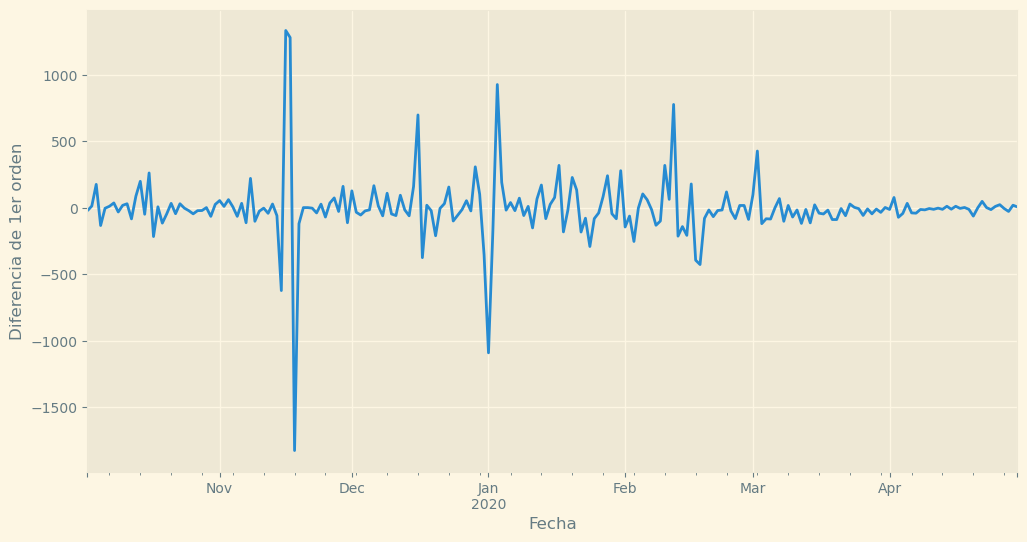

In [50]:
plt.rcParams["figure.figsize"] = (12,6)
pd_sales_multistore_1004767_diff_primer_orden.plot(legend=False, xlabel="Fecha", ylabel="Diferencia de 1er orden")
plt.show()

Repetimos el test ADF:

In [51]:
resultado_adf = adfuller(pd_sales_multistore_1004767_diff_primer_orden)

In [52]:
pval = resultado_adf[1]

print("El valor 'p' en el test ADF es {}".format(pval))

El valor 'p' en el test ADF es 2.2461522238509557e-18


El resultado es incluso que mejor que cuando hemos aplicado la estrategia de la resta de la media semanal.

Vamos a probar con la aplicación de una diferencia recurrente (función de numpy).

#### 3.2.3 Diferencia recurrente (función numpy)

In [63]:
pd_sales_multistore_1004767_diff_segundo_orden = pd_sales_multistore_1004767_daily.copy() 
pd_sales_multistore_1004767_diff_segundo_orden['units_sold'] = \
np.append([np.nan] * 2, np.diff(pd_sales_multistore_1004767_diff_segundo_orden['units_sold'], n=2))
pd_sales_multistore_1004767_diff_segundo_orden.dropna()

,units_sold
event_time,
2019-10-03 00:00:00+00:00,36.0
2019-10-04 00:00:00+00:00,163.0
2019-10-05 00:00:00+00:00,-310.0
2019-10-06 00:00:00+00:00,130.0
2019-10-07 00:00:00+00:00,15.0
...,...
2020-04-26 00:00:00+00:00,13.0
2020-04-27 00:00:00+00:00,-29.0
2020-04-28 00:00:00+00:00,-22.0


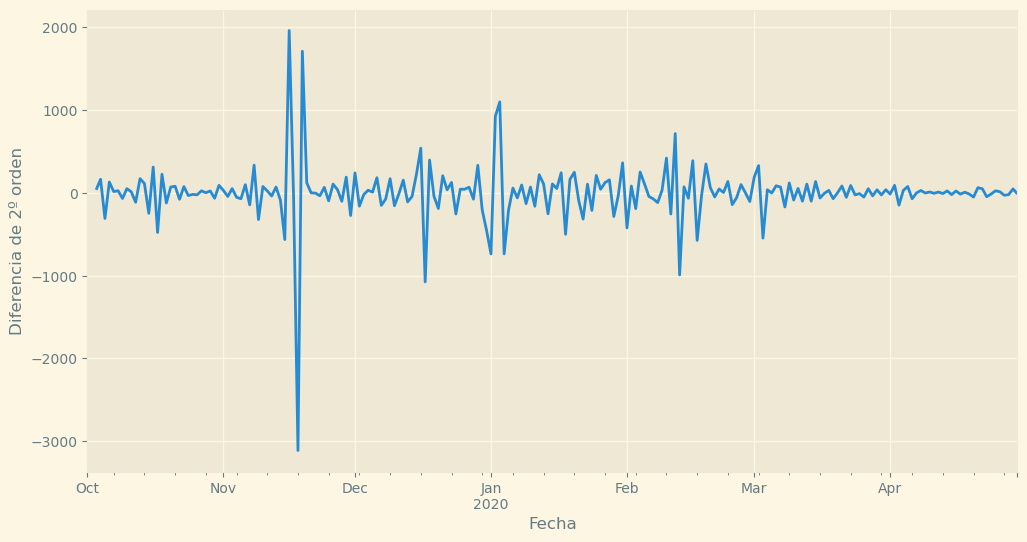

In [64]:
pd_sales_multistore_1004767_diff_segundo_orden.plot(legend=False, xlabel="Fecha", ylabel="Diferencia de 2º orden")
plt.show()

Pasamos el test ADF a la serie transformada:

In [69]:
pd_sales_multistore_1004767_diff_segundo_orden = pd_sales_multistore_1004767_diff_segundo_orden.dropna()

In [70]:
resultado_adf = adfuller(pd_sales_multistore_1004767_diff_segundo_orden)
pval = resultado_adf[1]

print("El valor 'p' en el test ADF es {}".format(pval))

El valor 'p' en el test ADF es 9.706893380414543e-13


El resultado también es bueno en este caso, pero el de la serie transformada mediante la diferencia de primer orden es el mejor, por lo que vamos a utilizarla.

### 3.3 ¿Estamos ante un *random walk*?

Para determinar si estamos ante un *random walk* volvemos a plotear la autocorrelación de la serie transformada.

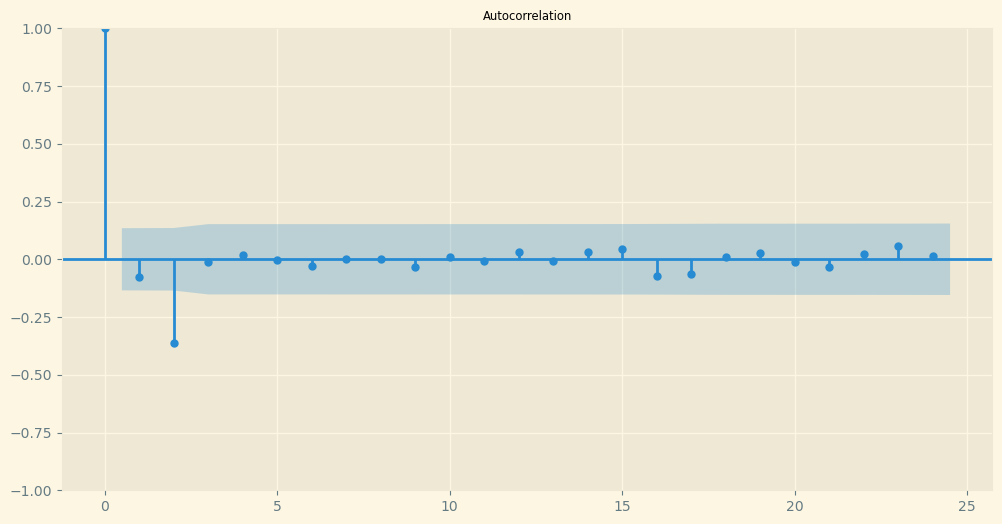

In [75]:
fig = plot_acf(pd_sales_multistore_1004767_diff_primer_orden)
plt.show()

Casi todos los coeficientes de correlación están dentro del área de no significancia, con lo cual evidentemente estamos ante un *random walk*.

No queda más remedio que recurrir a una predicción *ingenua*, con un horizonte de predicción muy próximo.

### 3.4 El problema de los outliers - uso del filtro Hampel

El filtro *Hampel* se utiliza generalmente para detectar anomalías en la estructura de una serie de tiempos. Consiste básicamente en una venta móvil de tiempo de tamaño parametrizable. El filtro obtiene la mediana de cada ventana y estima la desviación estándar 𝜎 de la ventana utilizando la desviación absoluta media. La observación es considerada un *outlier* cuando supera en 3 desviaciones estándar (este valor es parametrizable, ver *n* abajo) la mediana de la ventana, en cuyo caso el filtro sustituye el *outlier* por la mediana.

In [77]:
import hampel

In [78]:
pd_sales_multistore_1004767_daily_hampel = hampel.hampel(pd_sales_multistore_1004767_daily['units_sold'], \
window_size=7, n=4, imputation=True)

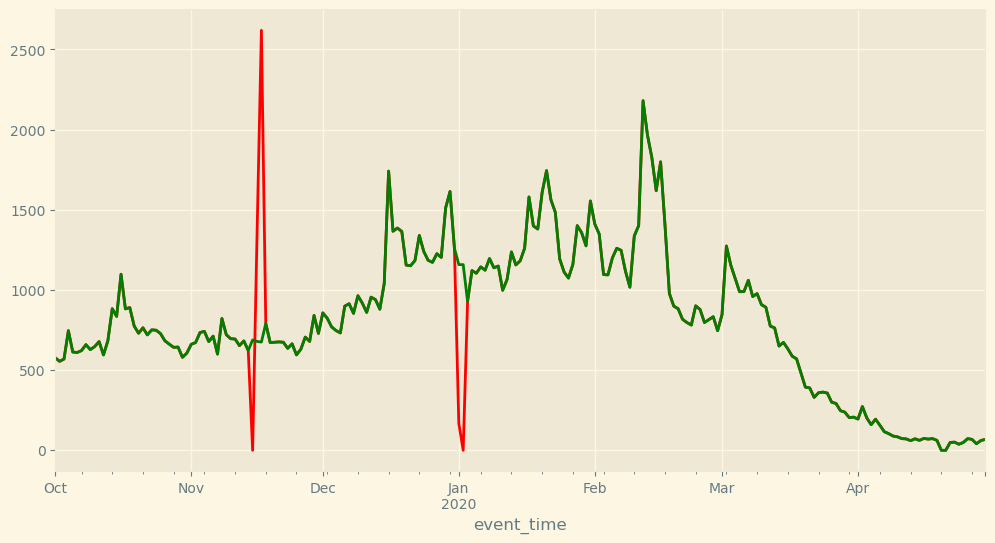

In [79]:
pd_sales_multistore_1004767_daily['units_sold'].plot(style="r-")
pd_sales_multistore_1004767_daily_hampel.plot(style="g-")
plt.show()

El efecto del filtro es muy bueno, con lo cual nos quedamos el resultado.

In [80]:
pd_sales_multistore_1004767_daily_hampel_diff_primer_orden = pd_sales_multistore_1004767_daily_hampel.diff().dropna() 

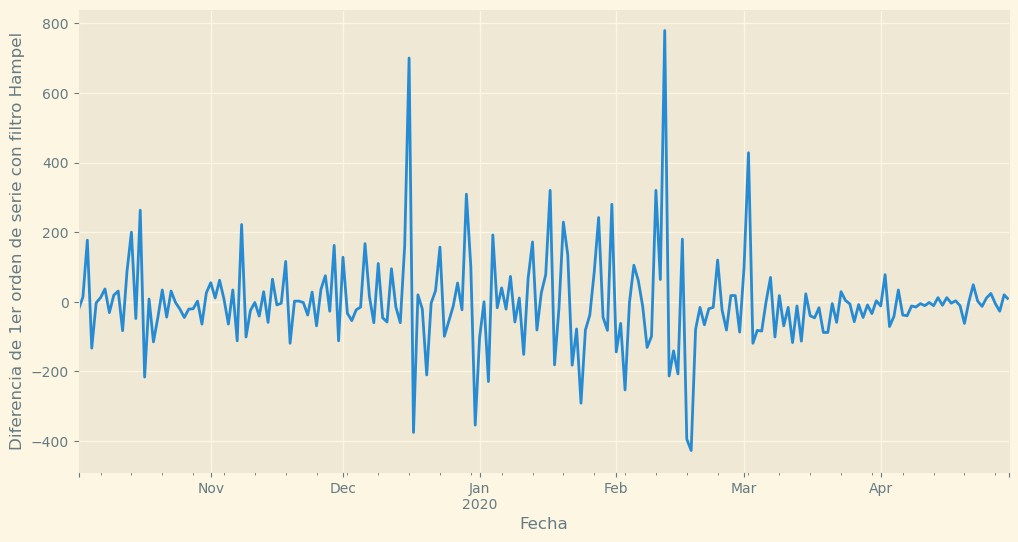

In [81]:
plt.rcParams["figure.figsize"] = (12,6)
pd_sales_multistore_1004767_daily_hampel_diff_primer_orden.plot(legend=False, xlabel="Fecha", \
ylabel="Diferencia de 1er orden de serie con filtro Hampel")
plt.show()

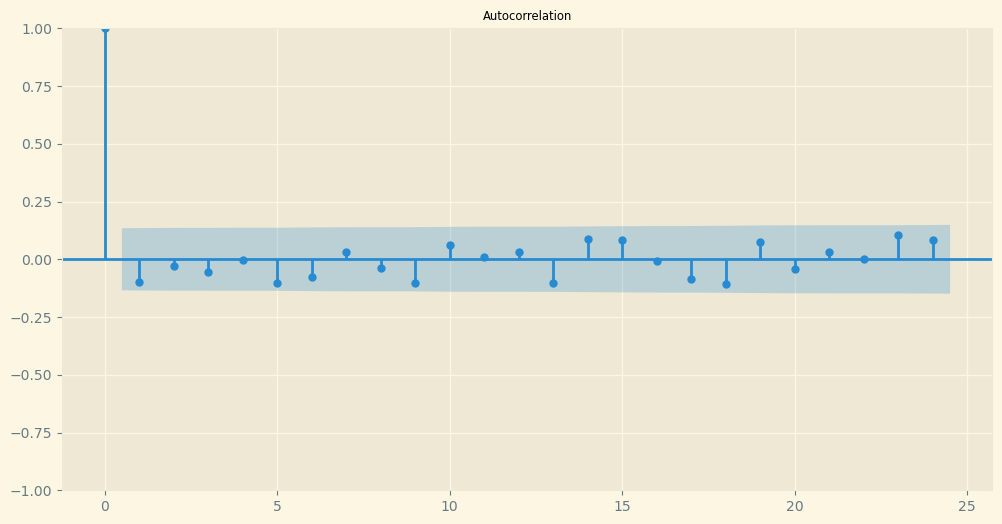

In [82]:
fig = plot_acf(pd_sales_multistore_1004767_daily_hampel_diff_primer_orden)
plt.show()

La verdad es que el filtro Hampel no nos ha ayudado a transformar nuestra serie de tiempos en una que no sea un *random walk*.